# 酷炫的3D UMAP 教程

最近工作太多了，没来的及更新，今天分享一个小知识，画超级酷炫的3D UMAP

### 载入需要的模块
如果没有的话就自己先建一个虚拟环境再一个一个安装就好，这没什么技巧的

In [32]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
#import louvain 因为我不怎么用这个包做聚类，所以我就给它注释掉了，完全不影响应用
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

import os

#doublet detection
import scrublet as scr
#batch correction (not installed by default in the docker container, install via command line: pip install scanorama bbknn)
import scanorama as scan
#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb 

In [33]:
import pandas as pd
import plotly.express as px
import plotly.offline as pyo

### 设置工作路径和文件的日期后缀，好习惯说一百次也不错

In [34]:
import os

# 定义目标路径
target_path = '/mnt/sdc/wwDatas/stereo_demo/D3umap/analysis'

# 检查路径是否存在，不存在则创建
if not os.path.exists(target_path):
    os.makedirs(target_path)
    print(f"路径 '{target_path}' 不存在，已创建该路径。")
else:
    print(f"路径 '{target_path}' 已存在。")

#日期后缀
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')
print(today)

# 设置当前工作目录
os.chdir(target_path)
print(f"当前工作目录已更改为: {os.getcwd()}")

路径 '/mnt/sdc/wwDatas/stereo_demo/D3umap/analysis' 已存在。
2025-11-04
当前工作目录已更改为: /mnt/sdc/wwDatas/stereo_demo/D3umap/analysis


### 载入数据
这里咱们的示例数据是进行过标准化降维聚类的

In [35]:
path=r"/mnt/sdc/wwDatas/stereo_demo/D3umap/adata_final_clean_fovea.h5ad"
adata = sc.read_h5ad(path)

### 先画一个2D的

In [36]:
adata

AnnData object with n_obs × n_vars = 19768 × 57118
    obs: 'cell_type_group', 'infomap_cluster', 'n_counts', 'region', 'source', 'cell_type', 'cell_id', 'condition', 'dataset', 'filtered_out_cells', 'tissue', 'ega_sample_alias', 'subject'
    var: 'gene', 'highly_variable'
    uns: 'cluster_name_colors', 'log1p', 'region_colors', 'source_colors'
    obsm: 'X_umap'

<Figure size 2000x2000 with 0 Axes>

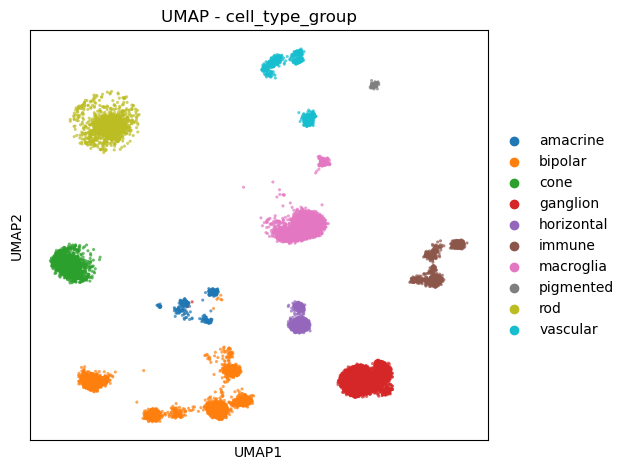

In [37]:
# 绘制基于细胞类型的UMAP图
plt.figure(figsize=(20, 20))
sc.pl.umap(
    adata,
    color='cell_type_group',          # 按细胞类型着色
    size=20,                    # 点的大小
    alpha=0.7,                  # 透明度
    #frameon=False,              # 去除边框
    #legend_loc='on data',       # 图例位置：在数据上
    title='UMAP - cell_type_group',  # 标题
    show=False                  # 不立即显示，便于保存
)
plt.tight_layout()
plt.show()

看一下目前的数据有几个维度，可以看到(19768, 2)这里面的2表示的是两个维度，也就是说现在只能画2D的

In [38]:
# 查看 UMAP 坐标的维度（行数是细胞数，列数是 UMAP 维度数）
print(adata.obsm['X_umap'].shape)

(19768, 2)


### 计算三维UMAP坐标
报错了，说还没运行找邻居的步骤，那好咱们先运行找邻居

In [39]:
# 1. 先计算邻居图（基于 PCA，默认使用 adata.obsm['X_pca']）
sc.pp.neighbors(adata)

# 2. 再计算 3D UMAP，并指定 key_added='3D_umap'
sc.tl.umap(adata, n_components=3, key_added='3D_umap')

/home/wangwen/Biosoft/ENTER/envs/scanpy/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:586: UserWarning:

You’re trying to run this on 57118 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.

/home/wangwen/Biosoft/ENTER/envs/scanpy/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



现在就可以啦，是三维的了

In [40]:
print(adata.obsm['3D_umap'].shape)  # 应该是 (19768, 3)

(19768, 3)


### 先画一个静态3D的

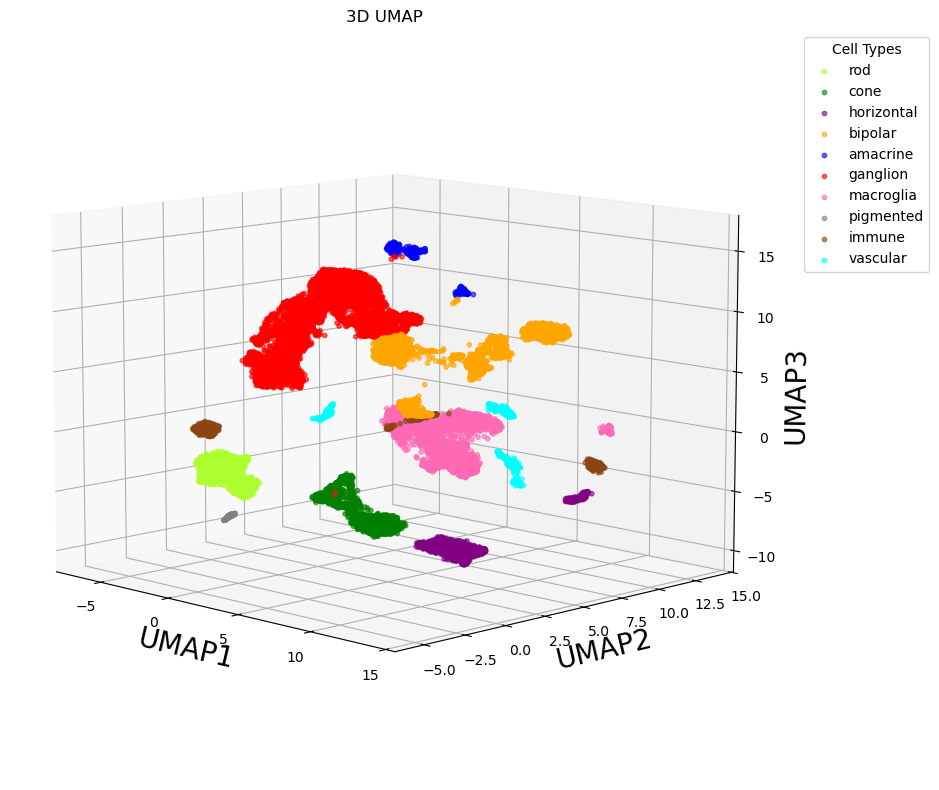

In [45]:
# ===========================
# 1. 获取 3D UMAP 坐标
# ===========================
umap_3d = adata.obsm['3D_umap']

# ===========================
# 2. 获取细胞类型列，并转为字符串
# ===========================
cluster_labels = adata.obs['cell_type_group'].astype(str)

# ===========================
# 3. 定义你自己的细胞类型颜色字典
# ===========================
cell_type_colors = {
    "amacrine": "#0000FF",       # 蓝色
    "bipolar": "#FFA500",        # 橙色
    "cone": "#008000",           # 绿色
    "ganglion": "#FF0000",       # 红色
    "horizontal": "#800080",     # 紫色
    "immune": "#8B4513",         # 棕色
    "macroglia": "#FF69B4",      # 粉色
    "pigmented": "#808080",      # 灰色
    "rod": "#ADFF2F",            # 黄绿色
    "vascular": "#00FFFF"        # 青色
}

# ===========================
# 4. 将每个细胞类型映射到对应颜色，未知的设为默认灰色
# ===========================
cell_colors = cluster_labels.map(cell_type_colors)
cell_colors = cell_colors.fillna("#CCCCCC")  # 未知类型用浅灰色

# ===========================
# 5. 获取所有唯一的细胞类型（关键！你之前漏了这一行）
# ===========================
unique_clusters = cluster_labels.unique()  # ✅ 修复 NameError

# ===========================
# 6. 画 3D UMAP 散点图
# ===========================
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 遍历每个唯一的细胞类型，画对应颜色的点
for i, cluster in enumerate(unique_clusters):
    mask = cluster_labels == cluster
    ax.scatter(
        umap_3d[mask, 0],  # UMAP1
        umap_3d[mask, 1],  # UMAP2
        umap_3d[mask, 2],  # UMAP3
        color=cell_type_colors.get(cluster, "#CCCCCC"),  # 从字典取颜色，没有则默认灰色
        label=f'{cluster}',  # 图例显示细胞类型名称
        alpha=0.6,
        s=10  # 点的大小
    )

# ===========================
# 7. 设置坐标轴、标题和图例
# ===========================
ax.set_xlabel('UMAP1', fontsize=20)
ax.set_ylabel('UMAP2', fontsize=20)
ax.set_zlabel('UMAP3', fontsize=20)
ax.set_title('3D UMAP')

# 添加图例（放在图外右侧）
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Cell Types")

# ===========================
# 7. 设置视角（推荐角度）
# ===========================
ax.view_init(elev=10, azim=-45)
# ===========================
# 8. 去掉所有背景、网格、填充，只保留坐标轴和散点
# ===========================
#ax.xaxis.pane.fill = False      # 不填充 X 轴所在平面（通常是灰/白）
#ax.yaxis.pane.fill = False      # 不填充 Y 轴所在平面
#ax.zaxis.pane.fill = False      # 不填充 Z 轴所在平面

#ax.xaxis.pane.set_edgecolor('black')  # 可选：设置坐标轴边缘颜色（默认可能是浅色）
#ax.yaxis.pane.set_edgecolor('black')
#ax.zaxis.pane.set_edgecolor('black')

#ax.grid(False)                  # 不显示任何网格线
#ax.xaxis._axinfo['grid']['color'] = 'none'  # 确保 X 网格不显示
#ax.yaxis._axinfo['grid']['color'] = 'none'  # 确保 Y 网格不显示
#ax.zaxis._axinfo['grid']['color'] = 'none'  # 确保 Z 网格不显示

# 设置坐标轴线条颜色（可选，比如黑色）
#ax.xaxis.pane.set_alpha(0.0)    # 透明化 X 轴背景平面
#ax.yaxis.pane.set_alpha(0.0)    # 透明化 Y 轴背景平面
#ax.zaxis.pane.set_alpha(0.0)    # 透明化 Z 轴背景平面

# 可选：设置坐标轴颜色为黑色，更清晰
#ax.xaxis.label.set_color('black')
#ax.yaxis.label.set_color('black')
#ax.zaxis.label.set_color('black')
#ax.tick_params(axis='x', colors='black')
#ax.tick_params(axis='y', colors='black')
#ax.tick_params(axis='z', colors='black')
# ===========================
# ✅ 11. 去掉坐标轴上的刻度数字（如 0, 2, 4, ...）→ 重点！
# ===========================
#ax.set_xticklabels([])  # 去掉 X 轴数字
#ax.set_yticklabels([])  # 去掉 Y 轴数字
#ax.set_zticklabels([])  # 去掉 Z 轴数字

# 设置整个 3D 图的背景为透明或纯白/纯黑（可选）
fig.patch.set_facecolor('none')  # 整个 figure 背景为白色（可改成 'none' 为透明）
ax.set_facecolor('none')          # 3D 坐标系背景设为透明（关键！）
# ===========================
# 9. 保存为 SVG 矢量图
# ===========================
#plt.savefig(f'3d_umap_cell_types_{today}1.svg', format='svg', dpi=300, bbox_inches='tight')
#plt.savefig(f'3d_umap_cell_types_{today}1.tiff', format='tiff', dpi=300, bbox_inches='tight')
# 调整布局并显示
plt.tight_layout()
plt.show()

### 再画一个动态的，这个会生成一个.html文件双击打开就是动态的3Dumap图，可以用鼠标看各种视角

In [42]:

# =========================
# 1. 获取 3D UMAP 坐标
# =========================
umap_3d = adata.obsm['3D_umap']  # 假定你已经计算并存好了 3D UMAP

# =========================
# 2. 构造绘图用的 DataFrame
# =========================
df = pd.DataFrame({
    'UMAP1': umap_3d[:, 0],
    'UMAP2': umap_3d[:, 1],
    'UMAP3': umap_3d[:, 2],
    'Cluster': adata.obs['cell_type_group'].astype(str)  # 确保是字符串类型
})

# =========================
# 3. 定义你想要的细胞类型与颜色的映射
# =========================
cell_type_colors = {
    "amacrine": "#0000FF",       # 蓝色
    "bipolar": "#FFA500",        # 橙色
    "cone": "#008000",           # 绿色
    "ganglion": "#FF0000",       # 红色
    "horizontal": "#800080",     # 紫色
    "immune": "#8B4513",         # 棕色
    "macroglia": "#FF69B4",      # 粉色
    "pigmented": "#808080",      # 灰色
    "rod": "#ADFF2F",            # 黄绿色
    "vascular": "#00FFFF"        # 青色
}

# =========================
# 4. 画 3D 散点图，并使用自定义颜色映射
# =========================
fig = px.scatter_3d(
    df,
    x='UMAP1',
    y='UMAP2',
    z='UMAP3',
    color='Cluster',  # 按照 Cluster 列（即 class_name）分组上色
    color_discrete_map=cell_type_colors,  # 🔥重点：使用你自定义的颜色
    title='Interactive 3D UMAP Colored by Cell Type',
    labels={
        'UMAP1': 'UMAP1',
        'UMAP2': 'UMAP2',
        'UMAP3': 'UMAP3',
        'Cluster': 'Cell Type'
    }
)

# =========================
# 5. （可选）调整点的大小和透明度，让图更美观
# =========================
fig.update_traces(
    marker=dict(
        size=8,        # 点的大小，可调整，比如 2~4
        opacity=1    # 透明度，避免重叠点完全遮住
    )
)

# =========================
# 6. 显示图形
# =========================


# =========================
# 7. （可选）保存为 HTML 文件，用于交互式展示或分享
# =========================
import plotly.offline as pyo
pyo.plot(fig, filename=f'3d_umap_cell_type_custom_colors_{today}.html')

'3d_umap_cell_type_custom_colors_2025-11-04.html'